In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%store -r all_tweets

In [149]:
# Start by grouping by day

tweet_by_date = all_tweets.groupby(by = all_tweets["tweet_created_at"].dt.floor('d'))

def digest_hashtags(tokenized_hashtags):
    hashtag_dict = {}
    for i in tokenized_hashtags:
        if not (len(i) == 1 and len(i[0].strip()) == 0):
            for hashtag in i:
                if hashtag.lower() not in hashtag_dict.keys():
                    hashtag_dict[hashtag.lower()] = 1
                else:
                    hashtag_dict[hashtag.lower()] = hashtag_dict[hashtag.lower()] + 1
    return(hashtag_dict)

hashtag_dict = {}
all_terms = []

# Digest days into hashtag counts
for group in tweet_by_date.groups:
    hashtag_dict[group] = digest_hashtags(tweet_by_date.get_group(group)['tokenized_hashtags'])
    if not len(all_terms):
        all_terms = list(hashtag_dict[group].keys())
    else:
        all_terms = all_terms + list(hashtag_dict[group].keys())

# For all terms not otherwise present in a day, set it to 0
for group in hashtag_dict.keys():
    for term in all_terms:
        if term not in hashtag_dict[group].keys():
            hashtag_dict[group][term] = 0

# Create a dataframe with days as rows and term counts as columns
hashtag_df = pd.DataFrame(hashtag_dict).transpose()
hashtag_df.head()
#print(hashtag_dict.keys())
#print(all_terms)
print(hashtag_df.shape)



(56, 28228)


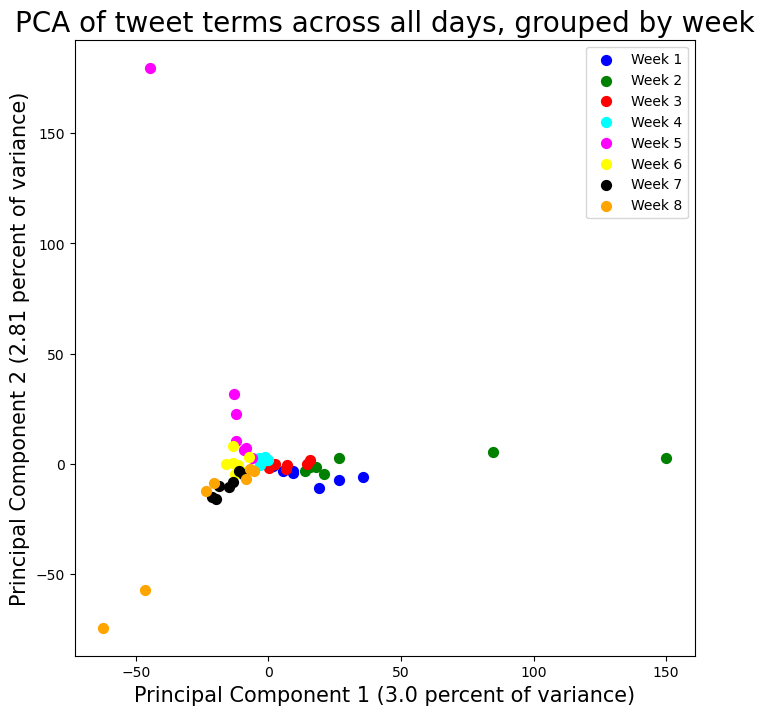

In [150]:
# Dimensional decomposition using PCA

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Start by assigning each day a week (week of collection)
hashtag_df["tweet_week"] = ""
hashtag_df.head()

# Iterating over rows isn't ideal, but there's < 60 of them
i = 0
k = 1
for row in hashtag_df.index:
    if i == 7:
        k = k + 1
        i = 0
    hashtag_df.at[row,"tweet_week"] = "Week %s"%(str(k))
    i = i + 1

tweet_colnames = hashtag_df.columns[:-1]
pca_values = hashtag_df.loc[:,tweet_colnames]
pca_target = hashtag_df.loc[:,['tweet_week']]

pca_values = StandardScaler().fit_transform(pca_values)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pca_values)
pca_df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
pca_df.index = pca_target.index
pca_df = pd.concat([pca_df,pca_target[['tweet_week']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1 (%s percent of variance)'%(round(pca.explained_variance_ratio_[0]*100,2)), fontsize = 15)
ax.set_ylabel('Principal Component 2 (%s percent of variance)'%(round(pca.explained_variance_ratio_[1]*100,2)), fontsize = 15)
ax.set_title('PCA of tweet terms across all days, grouped by week', fontsize = 20)
targets = ['Week 1','Week 2','Week 3','Week 4','Week 5','Week 6','Week 7','Week 8']
colors = ['blue', 'green', 'red','cyan','magenta','yellow','black','orange']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['tweet_week'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'principal component 1'], pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
ax.legend(targets)


Text(0.5, 1.0, 'UMAP projection of tweet terms across all days\n grouped by week')

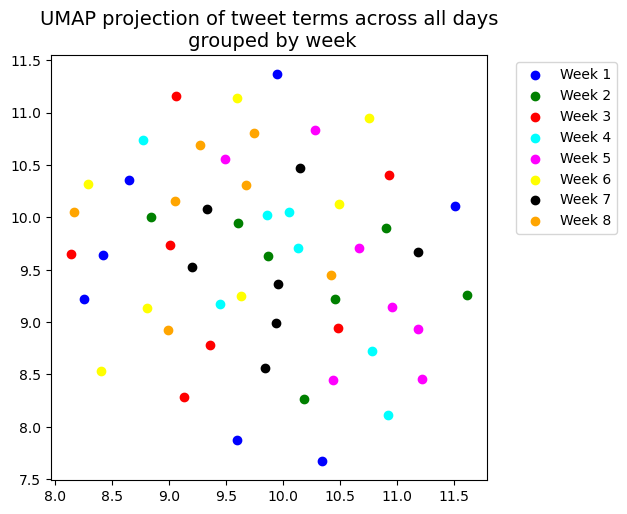

In [151]:
# Dimensional decomposition using UMAP

import umap.umap_ as umap

reducer = umap.UMAP()

hashtag_data = hashtag_df.loc[:, hashtag_df.columns != 'tweet_week'].values
hashtag_data[:10]
hashtag_data = StandardScaler().fit_transform(hashtag_data)
embedding = reducer.fit_transform(hashtag_data)

color_map = {"Week 1":'blue', "Week 2":'green', "Week 3":'red', "Week 4":'cyan', "Week 5":'magenta', "Week 6":'yellow', "Week 7":'black', "Week 8":'orange'}
labelled = {"Week 1":0, "Week 2":0, "Week 3":0, "Week 4":0, "Week 5":0, "Week 6":0, "Week 7":0, "Week 8":0}

for i in range(0,len(embedding)):
    if not labelled[hashtag_df.at[hashtag_df.index[i],"tweet_week"]]:
        labelled[hashtag_df.at[hashtag_df.index[i],"tweet_week"]] = 1
        plt.scatter(embedding[i,0],embedding[i,1],
                c = color_map[hashtag_df.at[hashtag_df.index[i],"tweet_week"]], 
                label = hashtag_df.at[hashtag_df.index[i],"tweet_week"])
    else:
        plt.scatter(embedding[i,0],embedding[i,1],
                c = color_map[hashtag_df.at[hashtag_df.index[i],"tweet_week"]])

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()

plt.title('UMAP projection of tweet terms across all days\n grouped by week', fontsize=14)

In [ ]:
# Building a classifier to determine major features that determine decision making

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, Y_train, Y_test = train_test_split(hashtag_df.loc[:,hashtag_df.columns[:-1]], hashtag_df['tweet_week'], random_state=0)

max_depth_range = list(range(1, 20))
for depth in max_depth_range:
    
    tree_classifier = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0)
    tree_classifier.fit(X_train, Y_train)
    score = tree_classifier.score(X_test, Y_test)
    plt.scatter(depth,score, c = 'black')
    
plt.xticks([x for x in max_depth_range])    
plt.title('Accuracy of classifier by tree depth', fontsize=14)

tree_classifier = DecisionTreeClassifier(max_depth = 7, 
                             random_state = 0)
tree_classifier.fit(X_train, Y_train)

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(tree_classifier.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
print(importances.head(15))

In [ ]:
# Rerun everything after adding a filter of atleast 100 occurences of a given tweet

term_counts = [x for x in hashtag_df.sum().iteritems()][:-1]
term_dict = {}
for term in term_counts:
    if term[1] > 100:
        term_dict[term[0]] = term[1]
term_dict_sorted = sorted(term_dict.items(), key=lambda x: x[1], reverse=True)
term_dict_sorted = term_dict_sorted[4:]
print(term_dict_sorted[:10])
print(len(term_dict_sorted))
term_dict_sorted_dict = {}
for item in term_dict_sorted:
    term_dict_sorted_dict[item[0]] = item[1]
#for_plotting = take(50,term_dict_sorted_dict.items())   
plt.rcParams['figure.figsize'] = [5, 12]
plt.barh([x[0] for x in term_dict_sorted[:50]],[x[1] for x in term_dict_sorted[:50]])
plt.title("Top 50 most frequently tweeted terms (outside of tweet filter)")
plt.xticks(rotation=80)
plt.gca().invert_yaxis()
plt.show()
plt.rcParams.update(plt.rcParamsDefault)


In [ ]:
list(term_dict_sorted_dict.keys())

hashtag_df = hashtag_df.loc[:,list(term_dict_sorted_dict.keys())+["tweet_week"]]

hashtag_df.head()

tweet_colnames = hashtag_df.columns[:-1]
pca_values = hashtag_df.loc[:,tweet_colnames]
pca_target = hashtag_df.loc[:,['tweet_week']]

pca_values = StandardScaler().fit_transform(pca_values)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(pca_values)
pca_df = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
pca_df.index = pca_target.index
pca_df = pd.concat([pca_df,pca_target[['tweet_week']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1 (%s percent of variance)'%(round(pca.explained_variance_ratio_[0]*100,2)), fontsize = 15)
ax.set_ylabel('Principal Component 2 (%s percent of variance)'%(round(pca.explained_variance_ratio_[1]*100,2)), fontsize = 15)
ax.set_title('PCA of tweet terms across all days, grouped by week', fontsize = 20)
targets = ['Week 1','Week 2','Week 3','Week 4','Week 5','Week 6','Week 7','Week 8']
colors = ['blue', 'green', 'red','cyan','magenta','yellow','black','orange']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['tweet_week'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'principal component 1'], pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
ax.legend(targets)

In [ ]:
# Plotting the major features of variation (top/bottom 20 features) within PC1 and PC2

top_20_features_1 = sorted(range(len(pca.components_[0])), key=lambda i: pca.components_[0][i], reverse=True)[:20]
bottom_20_features_1 = sorted(range(len(pca.components_[0])), key=lambda i: pca.components_[0][i])[:20]

feature_1_topics = list(hashtag_df.columns[bottom_20_features_1]) + list(hashtag_df.columns[top_20_features_1][::-1])
feature_1_scores = list(pca.components_[0][bottom_20_features_1].round(3)) + list(pca.components_[0][top_20_features_1][::-1].round(3))

top_20_features_2 = sorted(range(len(pca.components_[1])), key=lambda i: pca.components_[1][i], reverse=True)[:20]
bottom_20_features_2 = sorted(range(len(pca.components_[1])), key=lambda i: pca.components_[1][i])[:20]

feature_2_topics = list(hashtag_df.columns[bottom_20_features_2]) + list(hashtag_df.columns[top_20_features_2][::-1])
feature_2_scores = list(pca.components_[1][bottom_20_features_2].round(3)) + list(pca.components_[1][top_20_features_2][::-1].round(3))

plt.rcParams['figure.figsize'] = [3, 8]
plt.barh(np.arange(len(feature_1_scores)),feature_1_scores, 
        color = [('orange' if x < 0 else 'blue') for x in feature_1_scores])
plt.title("Drivers of variance within PC1 \n(top and bottom 20)")
plt.yticks(np.arange(len(feature_1_scores)),feature_1_topics)
plt.show()

plt.barh(np.arange(len(feature_2_scores)),feature_2_scores, 
        color = [('orange' if x < 0 else 'blue') for x in feature_2_scores])
plt.title("Drivers of variance within PC2 \n(top and bottom 20)")
plt.yticks(np.arange(len(feature_2_scores)),feature_2_topics)
plt.show()
plt.rcParams.update(plt.rcParamsDefault)



In [ ]:
hashtag_data = hashtag_df.loc[:, hashtag_df.columns != 'tweet_week'].values
hashtag_data = StandardScaler().fit_transform(hashtag_data)
embedding = reducer.fit_transform(hashtag_data)
embedding.shape
labelled = {"Week 1":0, "Week 2":0, "Week 3":0, "Week 4":0, "Week 5":0, "Week 6":0, "Week 7":0, "Week 8":0}

for i in range(0,len(embedding)):
    if not labelled[hashtag_df.at[hashtag_df.index[i],"tweet_week"]]:
        labelled[hashtag_df.at[hashtag_df.index[i],"tweet_week"]] = 1
        plt.scatter(embedding[i,0],embedding[i,1],
                c = color_map[hashtag_df.at[hashtag_df.index[i],"tweet_week"]], 
                label = hashtag_df.at[hashtag_df.index[i],"tweet_week"])
    else:
        plt.scatter(embedding[i,0],embedding[i,1],
                c = color_map[hashtag_df.at[hashtag_df.index[i],"tweet_week"]])

plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()
#plt.gca().set_aspect('equal', 'datalim')

plt.title('UMAP projection of tweet terms across all days\n grouped by week', fontsize=14)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(hashtag_df.loc[:,hashtag_df.columns[:-1]], hashtag_df['tweet_week'], random_state=0)

max_depth_range = list(range(1, 20))
for depth in max_depth_range:
    
    tree_classifier = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0)
    tree_classifier.fit(X_train, Y_train)
    score = tree_classifier.score(X_test, Y_test)
    plt.scatter(depth,score, c = 'black')
    
plt.xticks([x for x in max_depth_range])    
plt.title('Accuracy of classifier by tree depth', fontsize=14)

tree_classifier = DecisionTreeClassifier(max_depth = 7, 
                             random_state = 0)
tree_classifier.fit(X_train, Y_train)

importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(tree_classifier.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
print(importances.head(10))

In [ ]:
# Market basket analysis of frequent terms

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

hashtags_by_tweet = all_tweets.loc[:,'tokenized_hashtags'].to_numpy()
print(len(hashtags_by_tweet))
hashtags_by_tweet = np.array([x for x in hashtags_by_tweet if x != [''] and len(x) > 1])

print(len(hashtags_by_tweet))

#hashtags_by_tweet
te = TransactionEncoder()
te_tweets = te.fit(hashtags_by_tweet).transform(hashtags_by_tweet)
df = pd.DataFrame(te_tweets, columns=te.columns_)

#fp_out = fpmax(df.sample(n=10000,random_state=1), min_support=0.01, use_colnames=True)
fp_out = fpgrowth(df, min_support=0.02, use_colnames=True)

In [ ]:
freq_item_support = list(fp_out.loc[:,'support'].round(4))
freq_item_sets = list(fp_out.loc[:,'itemsets'])
labels = [','.join(list(x)) for x in freq_item_sets]

plt.rcParams['figure.figsize'] = [16, 4]
plt.bar(np.arange(len(freq_item_support)),freq_item_support)
plt.title("Frequent item sets (3% support)")
plt.xticks(np.arange(len(freq_item_support)),labels,rotation=90)
plt.show()
plt.rcParams.update(plt.rcParamsDefault)

In [ ]:
# Identifying association rules

rules = association_rules(fp_out, metric="confidence", min_threshold = 0.90)
rules

In [ ]:
# Identifying negatively correlated terms

rules = association_rules(fp_out, metric="lift", min_threshold = 0)
rules = rules[(rules["lift"] < 1)]
rules